In [1]:
import torch
import numpy as np
from pathlib import Path
import logging
from torch.utils.data import DataLoader
from dataset import ViTacVisDataset
from torch.utils.tensorboard import SummaryWriter
import argparse
from torch import nn
import torch.nn.functional as F

In [2]:
# parser = argparse.ArgumentParser("Train model.")
# parser.add_argument("--epochs", type=int, help="Number of epochs.", required=True)
# parser.add_argument("--data_dir", type=str, help="Path to data.", required=True)
# parser.add_argument(
#     "--checkpoint_dir", type=str, help="Path for saving checkpoints.", required=True
# )

# parser.add_argument("--lr", type=float, help="Learning rate.", required=True)
# parser.add_argument(
#     "--sample_file", type=int, help="Sample number to train from.", required=True
# )
# parser.add_argument(
#     "--batch_size", type=int, help="Batch Size.", required=True
# )

In [3]:
class FLAGS():
    def __init__(self):
        self.data_dir = '/home/tasbolat/some_python_examples/data_VT_SNN/'
        self.batch_size = 8
        self.sample_file = 1
        self.lr = 0.01
        self.epochs = 2000
        self.output_size = 20
args = FLAGS()

In [9]:
device = torch.device("cuda:1")

In [10]:
train_dataset = ViTacVisDataset(
    path=args.data_dir, sample_file=f"train_80_20_{args.sample_file}.txt", output_size=args.output_size
)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4
)
test_dataset = ViTacVisDataset(
    path=args.data_dir, sample_file=f"test_80_20_{args.sample_file}.txt", output_size=args.output_size
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4
)

In [11]:
class CNN3D(nn.Module):

    def __init__(self):
        
        super(CNN3D, self).__init__()
        self.input_size = 8*5*3
        self.hidden_dim = 32
        self.num_layers = 1
        
        self.conv1 = nn.Conv3d(in_channels=2, out_channels=2, kernel_size=(10,5,5), stride=(5,2,2))
        self.conv2 = nn.Conv3d(in_channels=2, out_channels=4, kernel_size=(5,3,3), stride=(3,2,2))
        self.conv3 = nn.Conv3d(in_channels=4, out_channels=8, kernel_size=(5,3,3), stride=(3,2,2))

        # Define the output layer
        self.fc = nn.Linear(np.prod([8, 6, 6, 5]), 20)
        
        self.drop = nn.Dropout(0.5)
    def forward(self, x):
        
        #print('Model input ', x.size())
        batch_size, C, H, W, sequence_size = x.size()
        x = x.view([batch_size, C, sequence_size, H, W])
        #print('Model input ', x.size())
        
        # pass to cnn3d
        out = self.conv1(x)
        out = F.relu(out)
        #print('conv1 out: ', out.shape)
        out = self.conv2(out)
        out = F.relu(out)
        #print('conv2 out: ', out.shape)
        out = self.conv3(out)
        out = F.relu(out)
        #print('conv3 out: ', out.shape)
        out = out.view([batch_size, np.prod([8, 6, 6, 5])])
        out = self.fc(out)
        # use dropout to have better generalization
        out = self.drop(out)
        return out

In [12]:
net = CNN3D().to(device)
# Create snn loss instance.
criterion = nn.CrossEntropyLoss()
# Define optimizer module.
optimizer = torch.optim.RMSprop(
    net.parameters(), lr=0.00001)

In [13]:
train_accs = []
test_accs = []
train_loss = []
test_loss = []
for epoch in range(1,args.epochs+1):
    # Training loop.
    net.train()
    correct = 0
    batch_loss = 0
    train_acc = 0
    for i, (in_viz, _, label) in enumerate(train_loader, 0):

        in_viz = in_viz.to(device)
        label = label.to(device)
        # Forward pass of the network.
        #print(in_viz.shape)
        out = net.forward(in_viz)
        #print(out_tact.shape)
        # Calculate loss.
        #print(label.shape)
        loss = criterion(out, label)
        #print(loss)

        batch_loss += loss.cpu().data.item()
        # Reset gradients to zero.
        optimizer.zero_grad()
        # Backward pass of the network.
        loss.backward()
        # Update weights.
        optimizer.step()

        _, predicted = torch.max(out.data, 1)
        correct += (predicted == label).sum().item()

    # Reset training stats.
    train_acc = correct/len(train_loader.dataset)
    train_loss.append(batch_loss/len(train_loader.dataset))
    train_accs.append(train_acc)
    #print(train_acc, batch_loss)

    # testing
    net.eval()
    correct = 0
    batch_loss = 0
    test_acc = 0
    with torch.no_grad():
        for i, (in_viz, _, label) in enumerate(test_loader, 0):
            in_viz = in_viz.to(device)
            # Forward pass of the network.
            out = net.forward(in_viz)
            label = label.to(device)
            _, predicted = torch.max(out.data, 1)
            correct += (predicted == label).sum().item()
            # Calculate loss.
            loss = criterion(out, label)
            batch_loss += loss.cpu().data.item()

    test_loss.append(batch_loss/len(test_loader.dataset))
    test_acc = correct/len(test_loader.dataset)
    test_accs.append(test_acc)
    if epoch%10 == 0:
        print(epoch, 'Train:', train_acc, 'Test:', test_acc)

10 Train: 0.09583333333333334 Test: 0.03333333333333333
20 Train: 0.20833333333333334 Test: 0.13333333333333333
30 Train: 0.21666666666666667 Test: 0.18333333333333332
40 Train: 0.325 Test: 0.23333333333333334
50 Train: 0.32916666666666666 Test: 0.26666666666666666
60 Train: 0.375 Test: 0.26666666666666666
70 Train: 0.37083333333333335 Test: 0.26666666666666666
80 Train: 0.4125 Test: 0.35
90 Train: 0.38333333333333336 Test: 0.31666666666666665
100 Train: 0.39166666666666666 Test: 0.3333333333333333
110 Train: 0.4666666666666667 Test: 0.35
120 Train: 0.4625 Test: 0.35
130 Train: 0.42083333333333334 Test: 0.3333333333333333
140 Train: 0.45 Test: 0.36666666666666664
150 Train: 0.5125 Test: 0.36666666666666664
160 Train: 0.4666666666666667 Test: 0.36666666666666664
170 Train: 0.5166666666666667 Test: 0.35
180 Train: 0.45 Test: 0.36666666666666664
190 Train: 0.5291666666666667 Test: 0.35
200 Train: 0.49583333333333335 Test: 0.4
210 Train: 0.5208333333333334 Test: 0.35
220 Train: 0.470833333

KeyboardInterrupt: 

In [14]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [15]:
params

31634

In [16]:
import matplotlib.pyplot as plt

In [17]:
np.max(test_accs)

0.75

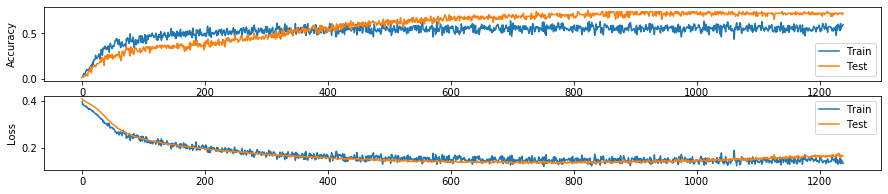

In [18]:
fig, ax = plt.subplots(2, figsize=(15,3))
ax[0].plot(train_accs)
ax[0].plot(test_accs)
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Test'])

ax[1].plot(train_loss) 
ax[1].plot(test_loss)
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Test'])

plt.show()